# Bifurcation diagrams of gw2 for 2:1

I'm trying to figure out why the 1d bifurcation diagram in the full model is "flipped" compared to the reduced model.

It is unclear if it's in how I set up the model equations, or if there is a calculation error.

The homogeneous case works well enough. but with even a tiny bit of heterogeneity, the solutions don't match for small epsilon.

Well it appears that the "flip" was due to 1. not including delta in the psi calculations, and 2. there is a qualitative match in the dynamics for sufficiently small epsilon, consistent with first-order averaging. I've checked the same dynamics using the higher-order response functions and the dynamics are faithfully reproduced. so seeing as how the only first-order approximation is the averaging, I believe it's the averaging that's limiting the accuracy here.

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import gw2

from lib.util import (get_phase, freq_est, get_tongue_1d, pl_exist_1d, 
get_period, bif1d, follow_phase_diffs, phase_lock_r3d, follow_locking_3d, 
get_initial_phase_diff_c, get_period)

from lib.rhs import _redu_c, _full, _redu_full
from lib.rhs import _redu_3dc_thal as _redu_3dc

from lib.plot_util import add_diagram_1d_scatter, quick_plot_combined


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-8,'atol':1e-8,'method':'LSODA'}

In [3]:
pd1 = {'v1':.84,'v2':.42,'v4':.35,'v6':.35,'v8':1,
           'k1':1,'k2':1,'k3':.7,'k4':1,'k5':.7,
           'k6':1,'k7':.35,'k8':1,'K':0.5,'kc':1,
           'n':6,'L':0,'eps':0,'del':0,'om':1,'om_fix':1}

In [4]:
kws1 = {'var_names':['x','y','z','v'],
        'pardict':pd1,
        'rhs':gw2.rhs,
        'coupling':gw2.coupling,
        'init':np.array([.3882,.523,1.357,.4347,24.2]),
        'TN':2000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':[False,True,False,False,False],
        'i_bad_dx':[False,True,False,False,False],
        'max_iter':20,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
       'lc_prominence':.1,
       'factor':0.5}

## Defs

In [5]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [6]:
etup21 = (.001,.1,200)
eps_list21r = np.linspace(*etup21)

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

## Initialize Response Functions

In [8]:
system1 = rsp(idx=0,model_name='gw0',**kws1)
system2 = rsp(idx=1,model_name='gw1',**kws1)

mkdir ./data/gw0/
* Loading LC data...
self.T 6.283185307179586 omfix 3.859018323065443
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975382527
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/gw1/
* Loading LC data...
self.T 6.283185307179586 omfix 3.859018323065443
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975382527
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# del=0.0

In [9]:
del21_p0 = 0
a21_p0 = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=['h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',2),_m=('om1',1),
                    NH=1000,
                    save_fig=False,
                   del1=del21_p0)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...


### Get Branches Full

In [10]:
kw_p0 = {'a':a21_p0,'del1':del21_p0,'recompute':False,'bifdir':'bif1d_gw2/',
        '_full_rhs':_full}

In [11]:
data_p0_list = []

In [12]:
# top 1
dat = follow_phase_diffs(init=4,eps_init=0.01,eps_final=0.0775,
                         deps=.005,**kw_p0)
data_p0_list.append(dat)

In [13]:
dat = follow_phase_diffs(init=4,eps_init=0.01,eps_final=0.0005,deps=-.005,**kw_p0)
data_p0_list.append(dat)

In [14]:
dat = follow_phase_diffs(init=2,eps_init=0.08,eps_final=0.1,deps=.005,**kw_p0)
data_p0_list.append(dat)

In [15]:
dat = follow_phase_diffs(init=2,eps_init=0.08,eps_final=0.04,deps=-.005,**kw_p0)
data_p0_list.append(dat)

## Get Branches 3D

In [16]:
data_r3d_p0_list = []

In [17]:
# find init for this branch mid
_,init = phase_lock_r3d([4,0,0],a21_p0,.01,_redu_3dc)
print(init)

t_diff 4.34539878862819610, Y=[ 4.34539879 -0.01411754 -0.0176649 ]                                              
[ 4.3454 -0.0141 -0.0177]


In [18]:
# f
dat = follow_locking_3d(init,a21_p0,(.01,.15,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

In [19]:
# b
dat = follow_locking_3d(init,a21_p0,(.01,.005,-.001),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

## Plot

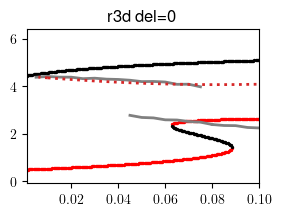

In [20]:
quick_plot_combined(a21_p0,
                    kw_f={'data_list':data_p0_list},
                    kw_r3d={'data_list':data_r3d_p0_list},
                    kw_r={'etup':etup21})

# del=0.0002

In [35]:
del21_p0002 = 0.0002
a21_p0002 = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=['h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',2),_m=('om1',1),
                    NH=1000,
                    save_fig=False,
                   del1=del21_p0002)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...
* Computing H gw1, order=0...
* Computing H gw0, order=1...
* Computing H gw1, order=1...


### Get Branches Full

In [22]:
kw_p0002 = {'a':a21_p0002,'del1':del21_p0002,'recompute':False,'bifdir':'bif1d_gw2/',
        '_full_rhs':_full}

In [25]:
data_p0002_list = []

In [26]:
# top 1
dat = follow_phase_diffs(init=4,eps_init=0.01,eps_final=0.08,
                         deps=.005,**kw_p0002)
data_p0002_list.append(dat)

init [0.38578185 0.51943975 1.35601047 0.1263677  0.15416057 0.73963238 2.43836757 0.084687   6.29430416]
eps iter 0 0.01                
t_diff [2.20357631].29e-08                                              
eps iter 1 0.015                
t_diff [2.18993717].13e-09                                              
eps iter 2 0.019999999999999997                
t_diff [2.18915674].78e-10                                              
eps iter 3 0.024999999999999998                
t_diff [2.15799141].25e-07                                              
eps iter 4 0.03                
t_diff [2.16820882].14e-07                                              
eps iter 5 0.034999999999999996                
t_diff [2.14852993].74e-08                                              
eps iter 6 0.039999999999999994                
t_diff [2.1419557]5.35e-09                                              
eps iter 7 0.045                
t_diff [2.12565253].31e-09                                   

In [27]:
dat = follow_phase_diffs(init=4,eps_init=0.01,eps_final=0.0005,deps=-.005,**kw_p0002)
data_p0002_list.append(dat)

In [28]:
dat = follow_phase_diffs(init=2,eps_init=0.08,eps_final=0.1,deps=.005,**kw_p0002)
data_p0002_list.append(dat)

In [29]:
dat = follow_phase_diffs(init=2,eps_init=0.08,eps_final=0.03,deps=-.005,**kw_p0002)
data_p0002_list.append(dat)

init [0.38468549 0.52126415 1.36174328 0.12626008 0.06214137 0.06683141 1.53555404 0.013823   6.20780636]
eps iter 0 0.08                
t_diff [-5.1342312].19e-07                                              
eps iter 1 0.075                
t_diff [-5.07927312]44e-07                                              
eps iter 2 0.06999999999999999                
t_diff [-5.05956525]11e-07                                              
eps iter 3 0.06499999999999999                
t_diff [-5.02338415]51e-07                                              
eps iter 4 0.059999999999999984                
t_diff [-5.01518029]38e-09                                              
eps iter 5 0.05499999999999998                
t_diff [-4.97051744]17e-09                                              
eps iter 6 0.049999999999999975                
t_diff [-4.95752295]39e-07                                              
eps iter 7 0.04499999999999997                
t_diff [-4.90926772]85e-08        

## Get Branches 3D

In [36]:
data_r3d_p0002_list = []

In [37]:
# find init for this branch mid
_,init = phase_lock_r3d([4,0,0],a21_p0002,.01,_redu_3dc)
print(init)

t_diff 4.41513504015771211, Y=[ 4.41513504 -0.01363668 -0.01730161]                                              
[ 4.4151 -0.0136 -0.0173]


In [38]:
# f
dat = follow_locking_3d(init,a21_p0002,(.01,.15,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0002_list.append(dat)

eps iter 0 0.01                
t_diff 4.41513504015773508, Y=[ 4.41513504 -0.01363668 -0.01730161]                                              
eps iter 1 0.02                
t_diff 4.35033024320093411, Y=[ 4.35033024 -0.02825574 -0.03527808]                                              
eps iter 2 0.03                
t_diff 4.29049992839050710, Y=[ 4.29049993 -0.04362693 -0.05379165]                                              
eps iter 3 0.04                
t_diff 4.23790055992552610, Y=[ 4.23790056 -0.05944268 -0.07267832]                                              
eps iter 4 0.05                
t_diff 4.19425089526094109, Y=[ 4.1942509  -0.07534609 -0.0917671 ]                                              
eps iter 5 0.060000000000000005                
t_diff 4.16062102447325210, Y=[ 4.16062102 -0.09095574 -0.11089035]                                              
eps iter 6 0.06999999999999999                
t_diff 4.13754397995018210, Y=[ 4.13754398 -0.10587546 -0.129

In [39]:
# b
dat = follow_locking_3d(init,a21_p0002,(.01,.005,-.001),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0002_list.append(dat)

eps iter 0 0.01                
t_diff 4.41513504015773508, Y=[ 4.41513504 -0.01363668 -0.01730161]                                              
eps iter 1 0.009000000000000001                
t_diff 4.42179375558466810, Y=[ 4.42179376 -0.01222579 -0.01553914]                                              
eps iter 2 0.008000000000000002                
t_diff 4.42847486764785110, Y=[ 4.42847487 -0.01082499 -0.01378358]                                              
eps iter 3 0.007000000000000003                
t_diff 4.43517563277866-10, Y=[ 4.43517563 -0.00943444 -0.01203503]                                              
eps iter 4 0.006000000000000004                
t_diff 4.44189434767303750, Y=[ 4.44189435 -0.00805431 -0.0102936 ]                                              


## Plot

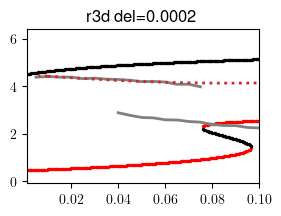

In [40]:
quick_plot_combined(a21_p0002,
                    kw_f={'data_list':data_p0002_list},
                    kw_r3d={'data_list':data_r3d_p0002_list},
                    kw_r={'etup':etup21})

# del=0.0004

In [41]:
del21_p0004 = 0.0004
a21_p0004 = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=['h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',2),_m=('om1',1),
                    NH=1000,
                    save_fig=False,
                   del1=del21_p0004)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...
* Computing H gw1, order=0...
* Computing H gw0, order=1...
* Computing H gw1, order=1...


### Get Branches Full

In [42]:
kw_p0004 = {'a':a21_p0004,'del1':del21_p0004,'recompute':False,'bifdir':'bif1d_gw2/',
        '_full_rhs':_full}

In [43]:
data_p0004_list = []

In [44]:
# top 1
dat = follow_phase_diffs(init=4,eps_init=0.01,eps_final=0.1,
                         deps=.005,**kw_p0004)
data_p0004_list.append(dat)

init [0.38580471 0.51945597 1.3560186  0.12637427 0.16148755 0.74506093 2.40071844 0.08806663 6.29393033]
eps iter 0 0.01                
t_diff [2.24566698].14e-09                                              
eps iter 1 0.015                
t_diff [2.24546119].07e-09                                              
eps iter 2 0.019999999999999997                
t_diff [2.24007283].92e-07                                              
eps iter 3 0.024999999999999998                
t_diff [2.24025688].65e-07                                              
eps iter 4 0.03                
t_diff [2.2454638]1.26e-07                                              
eps iter 5 0.034999999999999996                
t_diff [2.21649693].65e-08                                              
eps iter 6 0.039999999999999994                
t_diff [2.21703429].62e-08                                              
eps iter 7 0.045                
t_diff [2.21500706].67e-08                                   

In [45]:
dat = follow_phase_diffs(init=4,eps_init=0.01,eps_final=0.0005,deps=-.005,**kw_p0004)
data_p0004_list.append(dat)

init [0.38580471 0.51945597 1.3560186  0.12637427 0.16148755 0.74506093 2.40071844 0.08806663 6.29393033]
eps iter 0 0.01                
t_diff [2.24566698].14e-09                                              
eps iter 1 0.005                
t_diff [2.27621842].23e-08                                              


In [46]:
dat = follow_phase_diffs(init=2,eps_init=0.08,eps_final=0.1,deps=.005,**kw_p0004)
data_p0004_list.append(dat)

init [0.36783653 0.50916651 1.37118044 0.12129031 0.05571967 0.52390976 2.99873275 0.0313009  6.43585014]
eps iter 0 0.08                
t_diff [2.14949681].04e-07                                              
eps iter 1 0.085                
t_diff [2.14213079].58e-07                                              
eps iter 2 0.09000000000000001                
t_diff [2.11933944].36e-08                                              
eps iter 3 0.09500000000000001                
t_diff [2.11965228].98e-08                                              
eps iter 4 0.10000000000000002                
t_diff [2.08825731].72e-08                                              


In [47]:
dat = follow_phase_diffs(init=2,eps_init=0.08,eps_final=0.025,deps=-.005,**kw_p0004)
data_p0004_list.append(dat)

init [0.36783653 0.50916651 1.37118044 0.12129031 0.05571967 0.52390976 2.99873275 0.0313009  6.43585014]
eps iter 0 0.08                
t_diff [2.14949681].04e-07                                              
eps iter 1 0.075                
t_diff [2.14537371].64e-09                                              
eps iter 2 0.06999999999999999                
t_diff [2.17405526].07e-09                                              
eps iter 3 0.06499999999999999                
t_diff [2.18607123].00e-07                                              
eps iter 4 0.059999999999999984                
t_diff [2.19107249].45e-09                                              
eps iter 5 0.05499999999999998                
t_diff [2.20675741].42e-09                                              
eps iter 6 0.049999999999999975                
t_diff [2.22382561].29e-08                                              
eps iter 7 0.04499999999999997                
t_diff [2.22722459].98e-09        

## Get Branches 3D

In [48]:
data_r3d_p0004_list = []

In [53]:
# find init for this branch mid
_,init = phase_lock_r3d([5,0,0],a21_p0004,.01,_redu_3dc)
print(init)

t_diff 4.47817015677192213, Y=[ 4.47817016 -0.01320637 -0.01694039]                                              
[ 4.4782 -0.0132 -0.0169]


In [54]:
# f
dat = follow_locking_3d(init,a21_p0004,(.01,.1,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0004_list.append(dat)

eps iter 0 0.01                
t_diff 4.4781701567719e-08, Y=[ 4.47817016 -0.01320637 -0.01694039]                                              
eps iter 1 0.02                
t_diff 4.41656070922336-12, Y=[ 4.41656071 -0.02735575 -0.03456236]                                              
eps iter 2 0.03                
t_diff 4.35874510211581351, Y=[ 4.3587451  -0.04225251 -0.0527471 ]                                              
eps iter 3 0.04                
t_diff 4.30676933649362810, Y=[ 4.30676934 -0.05762484 -0.0713432 ]                                              
eps iter 4 0.05                
t_diff 4.26234359037009311, Y=[ 4.26234359 -0.07314468 -0.09018212]                                              
eps iter 5 0.060000000000000005                
t_diff 4.22669555444154411, Y=[ 4.22669555 -0.08844946 -0.1090898 ]                                              
eps iter 6 0.06999999999999999                
t_diff 4.20057862236443-10, Y=[ 4.20057862 -0.10315609 -0.127

In [55]:
# b
dat = follow_locking_3d(init,a21_p0004,(.01,.005,-.001),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0004_list.append(dat)

eps iter 0 0.01                
t_diff 4.4781701567719e-08, Y=[ 4.47817016 -0.01320637 -0.01694039]                                              
eps iter 1 0.009000000000000001                
t_diff 4.48445809425063610, Y=[ 4.48445809 -0.01184079 -0.01521408]                                              
eps iter 2 0.008000000000000002                
t_diff 4.49076071014073210, Y=[ 4.49076071 -0.01048486 -0.01349471]                                              
eps iter 3 0.007000000000000003                
t_diff 4.49707626314326-10, Y=[ 4.49707626 -0.00913873 -0.01178238]                                              
eps iter 4 0.006000000000000004                
t_diff 4.50340262669279410, Y=[ 4.50340263 -0.00780252 -0.01007719]                                              


## Plot

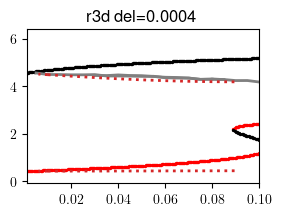

In [56]:
quick_plot_combined(a21_p0004,
                    kw_f={'data_list':data_p0004_list},
                    kw_r3d={'data_list':data_r3d_p0004_list},
                    kw_r={'etup':etup21})

# ==NEGATIVE==

# del=0.0002

In [57]:
del21_p0002b = -0.0002
a21_p0002b = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=['h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',2),_m=('om1',1),
                    NH=1000,
                    save_fig=False,
                   del1=del21_p0002b)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...
* Computing H gw1, order=0...
* Computing H gw0, order=1...
* Computing H gw1, order=1...


### Get Branches Full

In [58]:
kw_p0002b = {'a':a21_p0002b,'del1':del21_p0002b,'recompute':False,'bifdir':'bif1d_gw2/',
        '_full_rhs':_full}

In [59]:
data_p0002b_list = []

In [60]:
# top 1
dat = follow_phase_diffs(init=4,eps_init=0.01,eps_final=0.08,
                         deps=.005,**kw_p0002b)
data_p0002b_list.append(dat)

init [0.38577222 0.51942924 1.35600141 0.12636437 0.15052249 0.73662785 2.45731941 0.08297953 6.29448557]
eps iter 0 0.01                
t_diff [2.16716293].00e-07                                              
eps iter 1 0.015                
t_diff [2.14513494].25e-07                                              
eps iter 2 0.019999999999999997                
t_diff [2.13910655].65e-07                                              
eps iter 3 0.024999999999999998                
t_diff [2.12555544].60e-08                                              
eps iter 4 0.03                
t_diff [2.11467407].22e-09                                              
eps iter 5 0.034999999999999996                
t_diff [2.09972122].96e-07                                              
eps iter 6 0.039999999999999994                
t_diff [2.06304315].72e-09                                              
eps iter 7 0.045                
t_diff [2.05522068].83e-07                                   

In [61]:
dat = follow_phase_diffs(init=4,eps_init=0.01,eps_final=0.0005,deps=-.005,**kw_p0002b)
data_p0002b_list.append(dat)

init [0.38577222 0.51942924 1.35600141 0.12636437 0.15052249 0.73662785 2.45731941 0.08297953 6.29448557]
eps iter 0 0.01                
t_diff [2.16716293].00e-07                                              
eps iter 1 0.005                
t_diff [2.15078887].41e-08                                              


In [62]:
dat = follow_phase_diffs(init=2,eps_init=0.08,eps_final=0.1,deps=.005,**kw_p0002b)
data_p0002b_list.append(dat)

init [0.38535935 0.5217561  1.36144708 0.12646283 0.07032743 0.07144475 1.50083217 0.01558055 6.21830249]
eps iter 0 0.08                
t_diff [1.15370108]2.51e-08                                              
eps iter 1 0.085                
t_diff [1.14658875].58e-09                                              
eps iter 2 0.09000000000000001                
t_diff [1.10172981].10e-08                                              
eps iter 3 0.09500000000000001                
t_diff [1.10052406].56e-07                                              
eps iter 4 0.10000000000000002                
t_diff [1.06724295].13e-08                                              


In [63]:
dat = follow_phase_diffs(init=2,eps_init=0.08,eps_final=0.03,deps=-.005,**kw_p0002b)
data_p0002b_list.append(dat)

init [0.38535935 0.5217561  1.36144708 0.12646283 0.07032743 0.07144475 1.50083217 0.01558055 6.21830249]
eps iter 0 0.08                
t_diff [1.15370108]2.51e-08                                              
eps iter 1 0.075                
t_diff [-5.17982467]05e-08                                              
eps iter 2 0.06999999999999999                
t_diff [-5.14093257]35e-08                                              
eps iter 3 0.06499999999999999                
t_diff [-5.11480395]03e-07                                              
eps iter 4 0.059999999999999984                
t_diff [-5.09386792]58e-08                                              
eps iter 5 0.05499999999999998                
t_diff [-5.05101458]58e-07                                              
eps iter 6 0.049999999999999975                
t_diff [-5.02299477]82e-11                                              
eps iter 7 0.04499999999999997                
t_diff [-4.99953129]80e-08       

## Get Branches 3D

In [64]:
data_r3d_p0002b_list = []

In [65]:
# find init for this branch mid
_,init = phase_lock_r3d([4,0,0],a21_p0002b,.01,_redu_3dc)
print(init)

t_diff 4.26550196868481810, Y=[ 4.26550197 -0.01467207 -0.01803173]                                              
[ 4.2655 -0.0147 -0.018 ]


In [66]:
# f
dat = follow_locking_3d(init,a21_p0002b,(.01,.15,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0002b_list.append(dat)

eps iter 0 0.01                
t_diff 4.26550196868480909, Y=[ 4.26550197 -0.01467207 -0.01803173]                                              
eps iter 1 0.02                
t_diff 4.19126787039657410, Y=[ 4.19126787 -0.03043101 -0.03670085]                                              
eps iter 2 0.03                
t_diff 4.12581555656349959, Y=[ 4.12581556 -0.04694542 -0.05582237]                                              
eps iter 3 0.04                
t_diff 4.07201856118547309, Y=[ 4.07201856 -0.06381129 -0.07521416]                                              
eps iter 4 0.05                
t_diff 4.03133791849965809, Y=[ 4.03133792 -0.08060893 -0.09472263]                                              
eps iter 5 0.060000000000000005                
t_diff 4.00410010064093309, Y=[ 4.0041001  -0.09692595 -0.11421798]                                              
eps iter 6 0.06999999999999999                
t_diff 3.99005798958881959, Y=[ 3.99005799 -0.11234323 -0.133

In [67]:
# b
dat = follow_locking_3d(init,a21_p0002b,(.01,.005,-.001),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0002b_list.append(dat)

eps iter 0 0.01                
t_diff 4.26550196868480909, Y=[ 4.26550197 -0.01467207 -0.01803173]                                              
eps iter 1 0.009000000000000001                
t_diff 4.27326398456890509, Y=[ 4.27326398 -0.01315145 -0.01619702]                                              
eps iter 2 0.008000000000000002                
t_diff 4.28107123609267810, Y=[ 4.28107124 -0.01164207 -0.01436889]                                              
eps iter 3 0.007000000000000003                
t_diff 4.28892018400542909, Y=[ 4.28892018 -0.0101442  -0.01254751]                                              
eps iter 4 0.006000000000000004                
t_diff 4.29680648170883610, Y=[ 4.29680648 -0.00865807 -0.01073304]                                              


## Plot

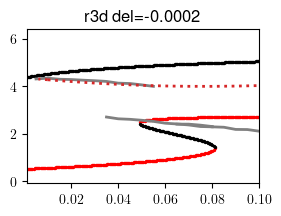

In [68]:
quick_plot_combined(a21_p0002b,
                    kw_f={'data_list':data_p0002b_list},
                    kw_r3d={'data_list':data_r3d_p0002b_list},
                    kw_r={'etup':etup21})